# Setup

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet scrnatools

In [2]:
import scrnatools as rna
import string
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import random
import os
import shutil

/home/joe/miniconda3/envs/scrnatools-testing/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/joe/miniconda3/envs/scrnatools-testing/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
rna.configs.verbosity = "info"
scvi.settings.seed = 0

Global seed set to 0


# Import data

Downloads and loads the 3k pbmc example dataset provided with scanpy <br>
Otherwise import your own datasets folling the documentation at https://scanpy.readthedocs.io/en/latest/api.html#reading

In [4]:
adata = sc.datasets.pbmc3k()
# Store the raw counts data in a layer
adata.layers["raw_counts"] = adata.X.copy()
# FOR DEMO ONLY
# This sample data is human so gene names are capitalized, but immgen data for cell type similarity is from mouse so gene names only have first letter capitalized
# For real data analysis, do not do this, use a human reference for similarity scoring instead
adata.var_names = [string.capwords(i) for i in adata.var_names]
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    layers: 'raw_counts'

# Doublet removal

Uses scrublet (https://github.com/swolock/scrublet) to filter out potential doublets in each batch

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


2023-08-17 19:54:15 - scrublet - INFO: 2.222% of cells classified as doublets (60 cells)


Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 41.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.6%
Elapsed time: 1.4 seconds
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 48.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.6%


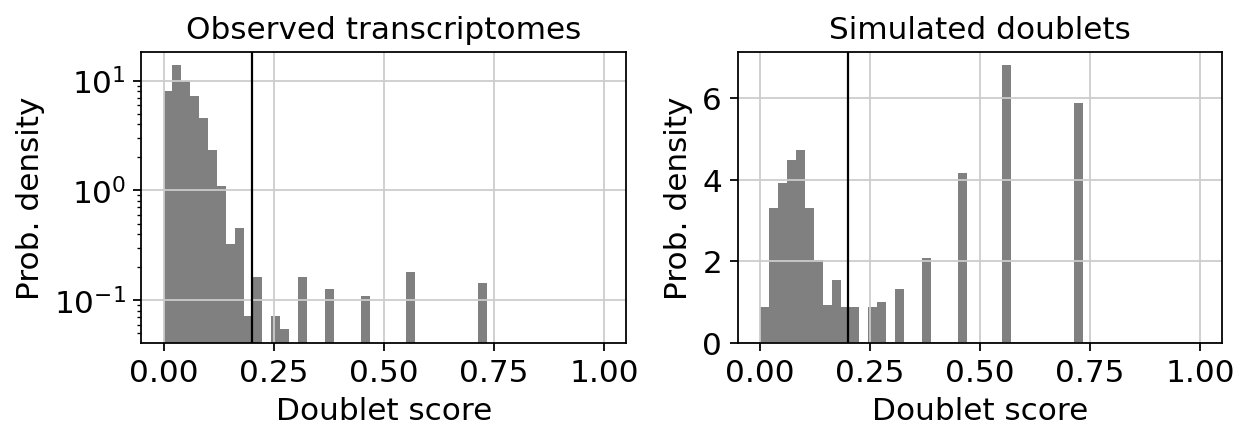

In [6]:
adata = rna.qc.scrublet(
    adata,
    doublet_threshold = 0.2, # Score threshold to use to call doublets
    batch_key = None, # Use batch information from a column in 'adata.obs' to run scrublet on each batch independently
    raw_counts_layer = "raw_counts" # use the raw counts data
)

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet'
    var: 'gene_ids'
    layers: 'raw_counts'

# Preprocessing

For details on using scanpy see https://scanpy.readthedocs.io/en/stable/

## Get QC metrics using scanpy

In [8]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

## Filter cells based on QC metrics

2023-08-17 19:54:16 - qc_plotting - INFO: Saving figure to analysis/qc_plots.png


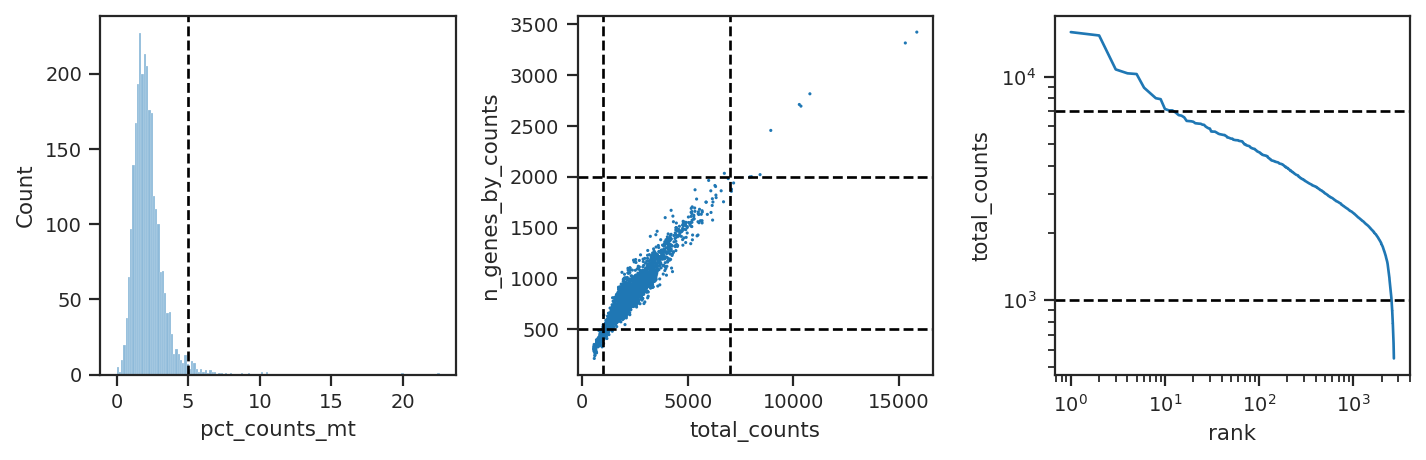

In [9]:
counts_thresholds=(1000, 7000) # The lower and upper total_counts thresholds
genes_thresholds=(500, 2000) # The lower and upper n_genes_by_counts thresholds
mt_threshold=5 # The pct_counts_mt threshold

rna.pl.qc_plotting(
    adata,
    counts_thresholds=counts_thresholds,
    genes_thresholds=genes_thresholds,
    mt_threshold=mt_threshold,
    show_thresholds=True, # Whether to show the thresholds on the figure
    batch_key=None, # Batch keys in adata.obs to plot seperately
    show_legend=False, # Whether to show the batch key legend
    figsize=(9, 3),
    dpi=300,
    save_path="analysis/qc_plots.png",
)

2023-08-17 19:54:17 - filter_cells - INFO: Number of cells before QC filtering: 2700
2023-08-17 19:54:17 - filter_cells - INFO: Number of cells after QC filtering: 2441
2023-08-17 19:54:17 - qc_plotting - INFO: Saving figure to analysis/filtered_qc_plots.png


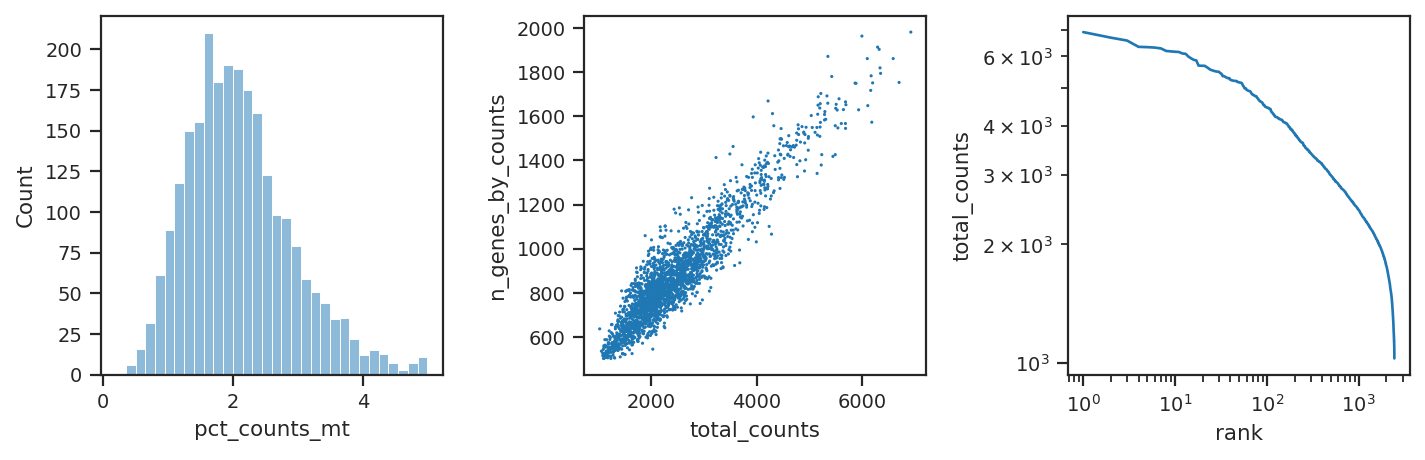

In [10]:
filteredAdata = rna.qc.filter_cells(
    adata,
    counts_thresholds=counts_thresholds, # The lower and upper total_counts thresholds
    genes_thresholds=genes_thresholds, # The lower and upper n_genes_by_counts thresholds
    mt_threshold=mt_threshold, # The pct_counts_mt threshold
)
rna.pl.qc_plotting(
    filteredAdata,
    show_thresholds=False,
    save_path="analysis/filtered_qc_plots.png",
)

In [11]:
# Once you're happy with qc cell filtering, overwrite adata with the filtered adata
adata = filteredAdata
del filteredAdata

## Log transform data with scanpy

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

## Subset genes

This step is recommended, but some analysis can be done using all genes instead of filtering genes by absolute expression or variability of expression

In [13]:
# Subset on highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200, # Number of HVGs to keep
    subset=True, # Subset the adata in place
    layer="raw_counts", # Use the raw counts data for calculations
    flavor="seurat_v3", # HVG algorithm to use
    batch_key=None, # Column in adata.obs that annotates batches of data
)

# Or subset on genes above minimum average expression threshold
# adata = adata[:, adata.var.mean_counts > 0.01].copy()

In [14]:
adata

AnnData object with n_obs × n_vars = 2441 × 1200
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'qc_plot_batch'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_counts'

## Normalize data with scanpy

This step is optional for use when downstream analysis is done within scanpy, otherwise scVI normalization can be done on its own

In [15]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# Scanpy normalized expression is now stored in adata.X

## Normalize data with scVI

For details on scVI usage see https://scvi-tools.org

In [16]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw_counts",
    batch_key=None,
)
model = scvi.model.SCVI(adata)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [17]:
# Train scVI model - run on google colab with a GPU session or a Windows machine with an Nvidia GPU
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|██████████| 400/400 [02:33<00:00,  2.60it/s, v_num=1, train_loss_step=393, train_loss_epoch=400]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:33<00:00,  2.61it/s, v_num=1, train_loss_step=393, train_loss_epoch=400]


In [18]:
if not os.path.isdir("data/scVI_models"):
    os.makedirs("data/scVI_models")
if os.path.isdir("data/scVI_models"):
    shutil.rmtree("data/scVI_models")
# save the scVI model and adata object before further processing because training is non-deterministic
model.save("data/scVI_models/pbmc_3k_1200_hvgs")
adata.write("data/pbmc_3k_1200_hvgs.h5ad")

In [19]:
# To reload saved adata/scVI model later:
adata = sc.read("data/pbmc_3k_1200_hvgs.h5ad")
model = scvi.model.SCVI.load("data/scVI_models/pbmc_3k_1200_hvgs", adata=adata)

INFO     File data/scVI_models/pbmc_3k_1200_hvgs/model.pt already downloaded                                       


In [20]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [21]:
adata

AnnData object with n_obs × n_vars = 2441 × 1200
    obs: 'scrublet_batch_key', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'qc_plot_batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'raw_counts', 'scVI_normalized'

# Dimensionality reduction

## UMAP

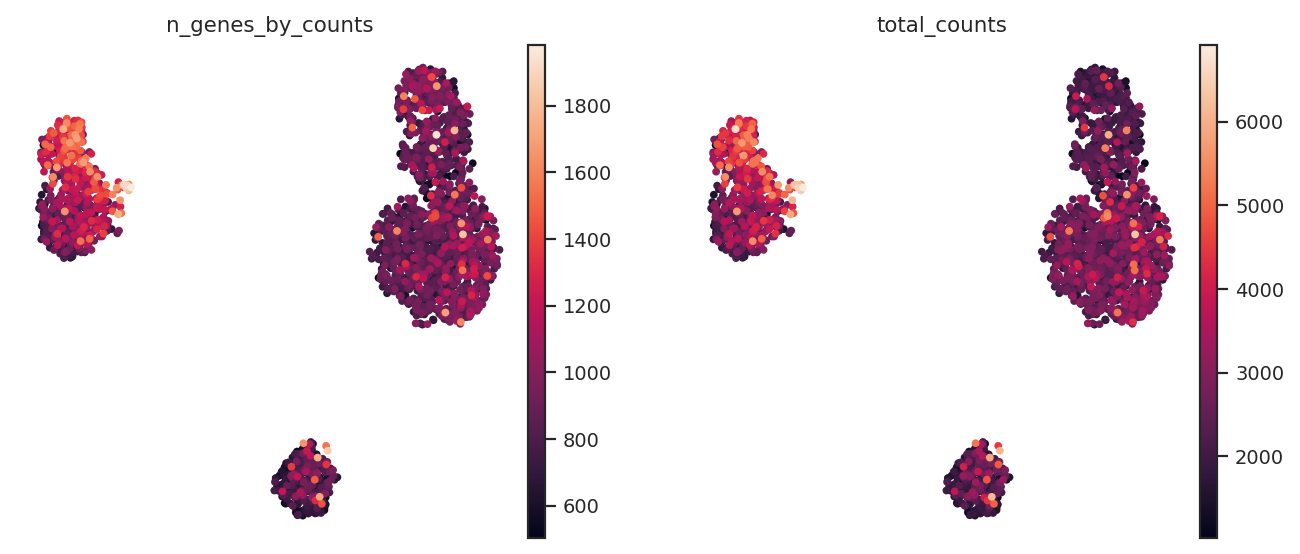

In [22]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts"],
)

## TSNE

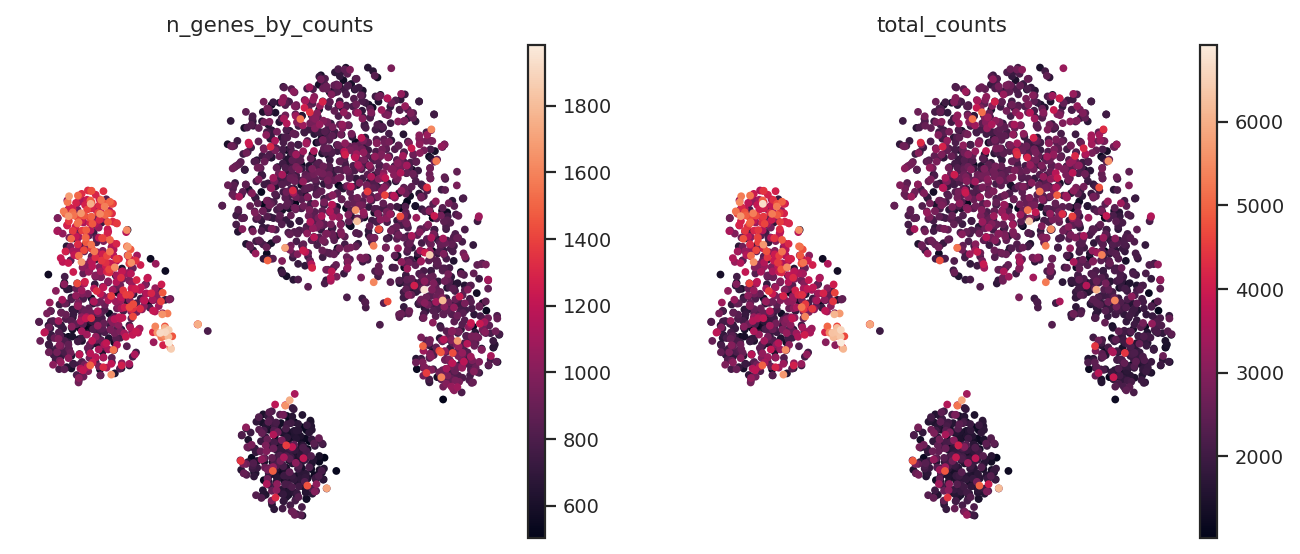

In [23]:
sc.tl.tsne(adata, use_rep="X_scVI")
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.tsne(
    adata,
    color=["n_genes_by_counts", "total_counts"],
)

# Clustering

/home/joe/miniconda3/envs/scrnatools-testing/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


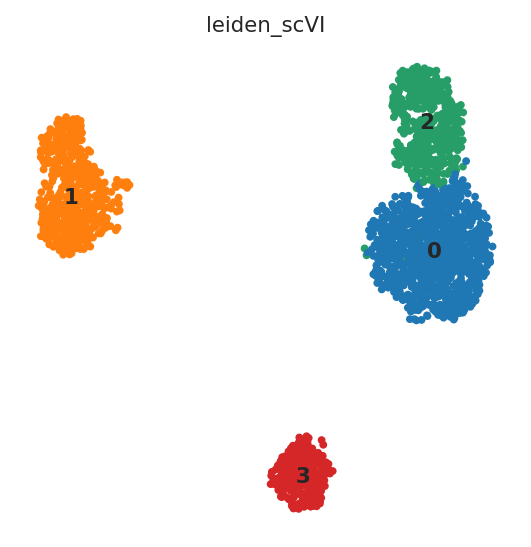

In [24]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
)

# Rename clusters to cell types

## Gene feature plots

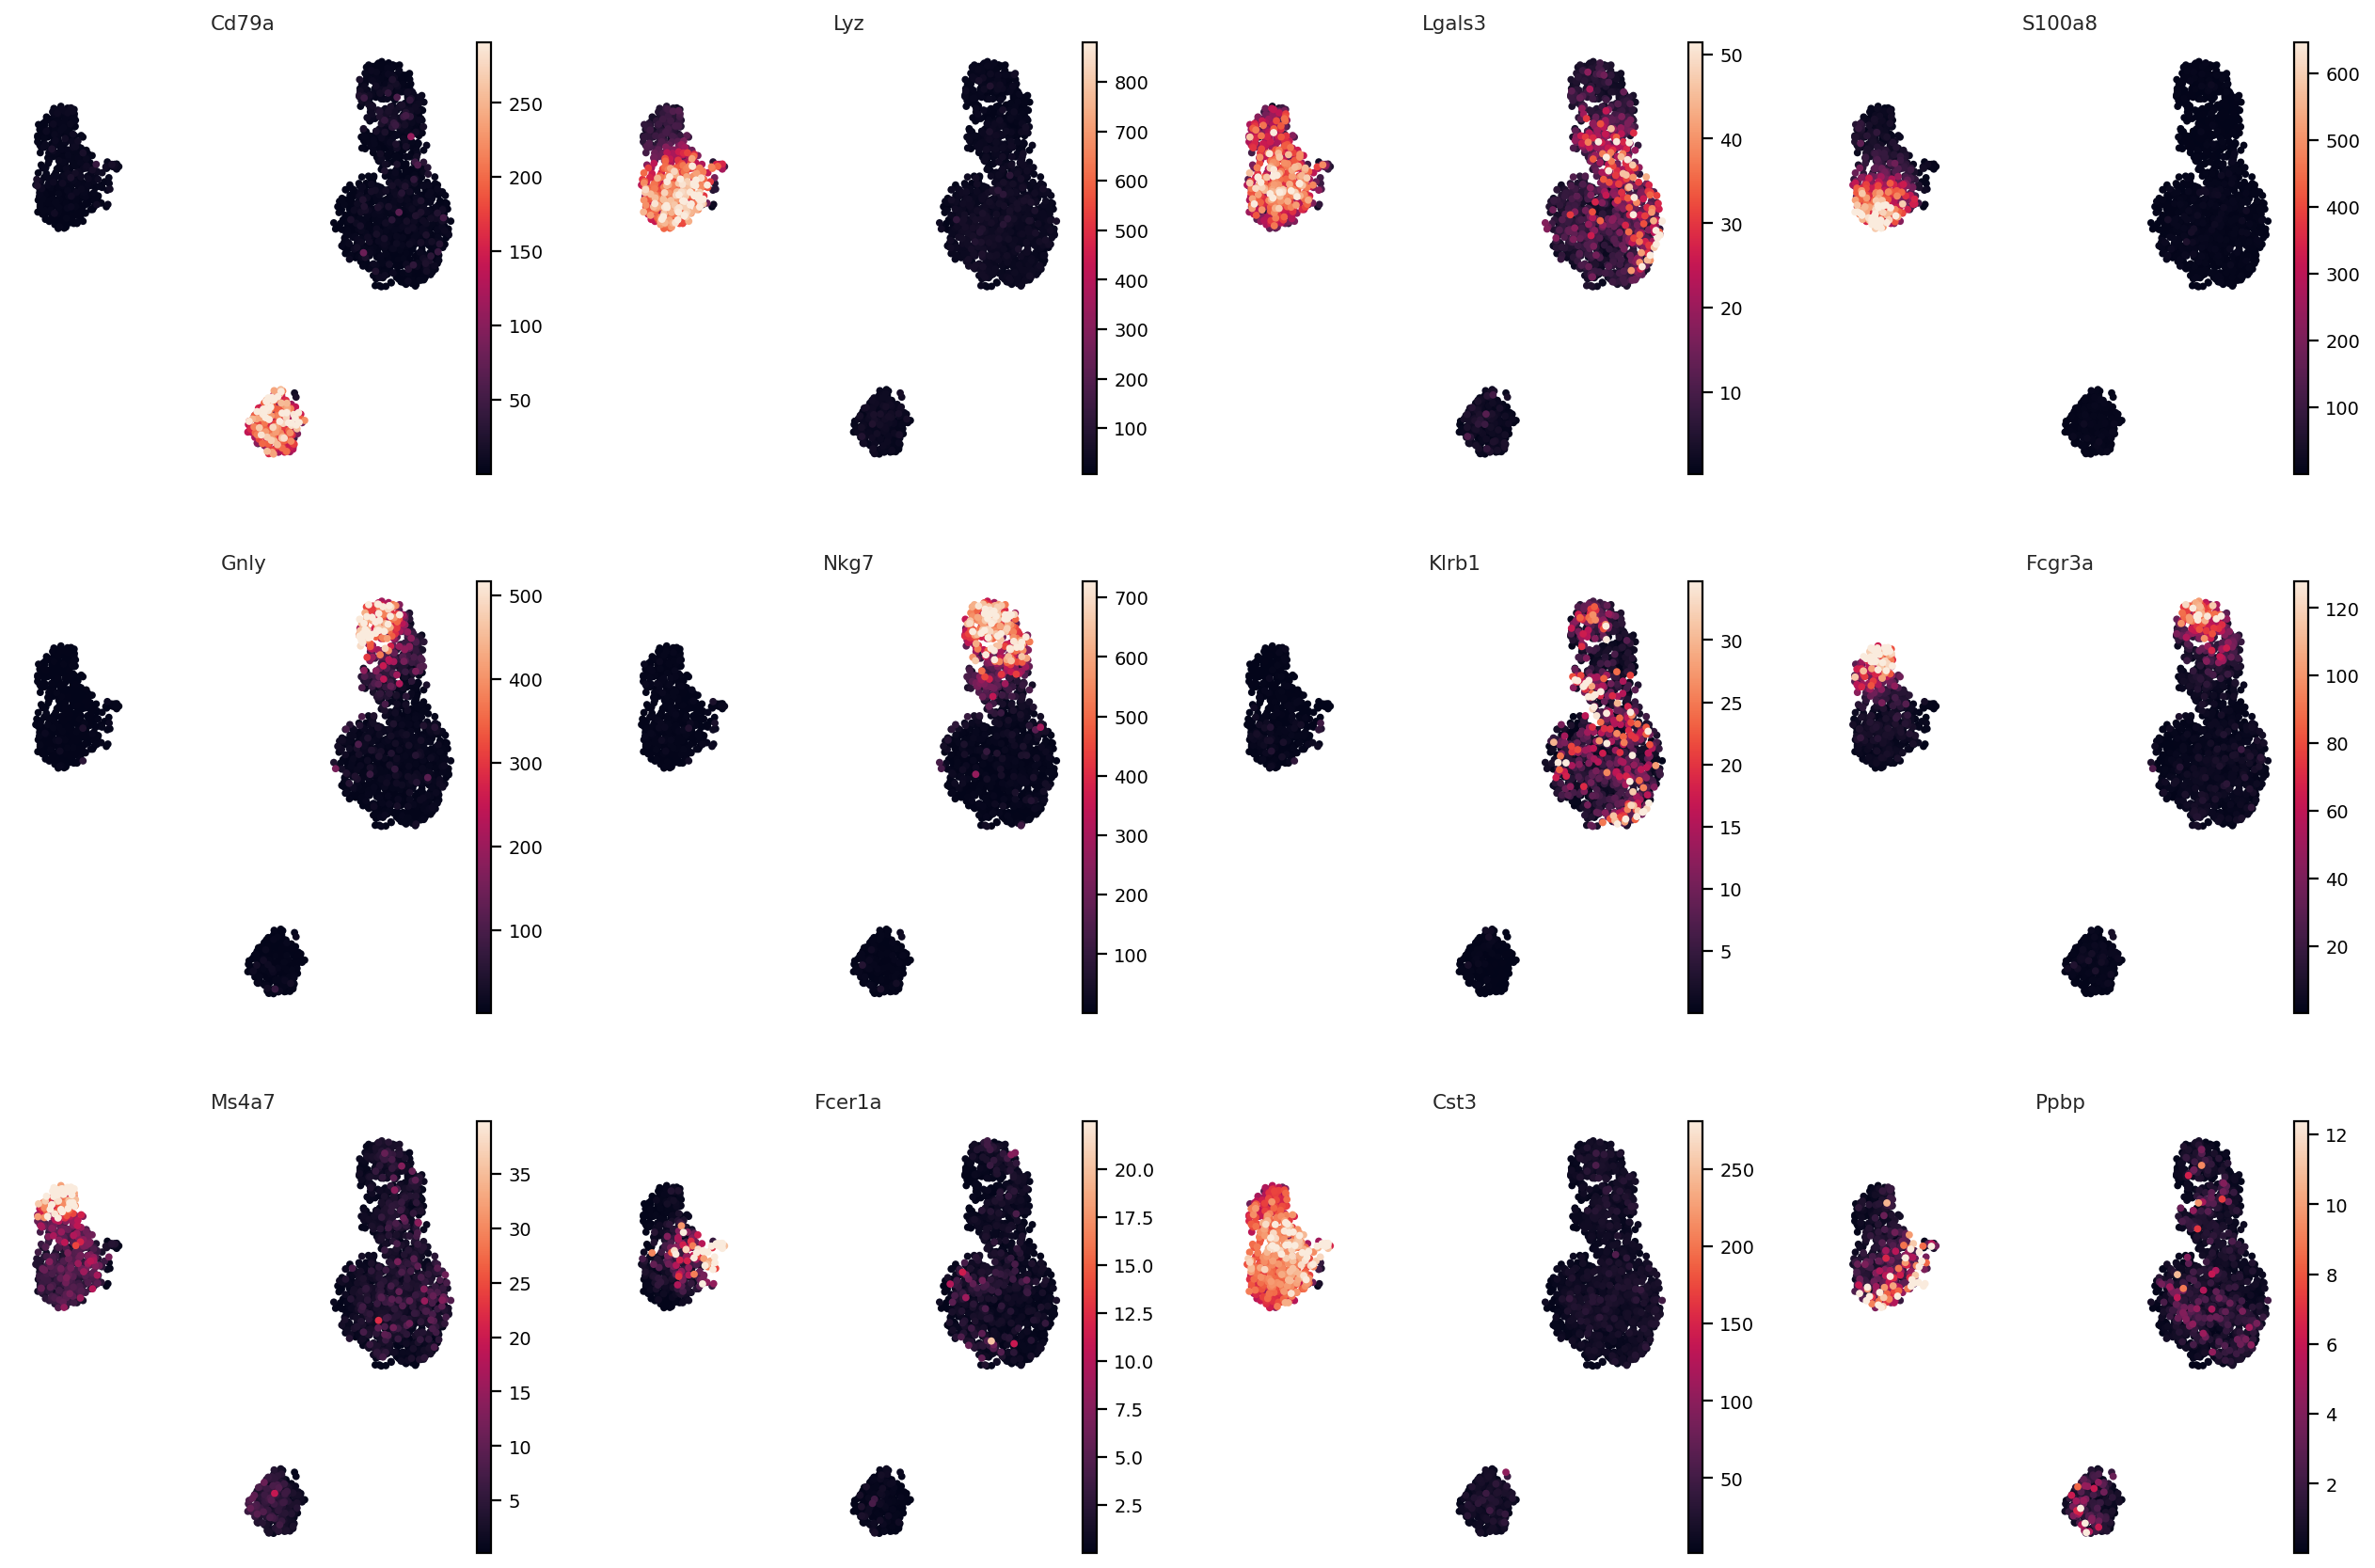

In [25]:
geneList = ["Cd79a", "Lyz", "Lgals3", "S100a8", "Gnly", "Nkg7", "Klrb1", "Fcgr3a", "Ms4a7", "Fcer1a", "Cst3", "Ppbp"]
sc.settings.figdir = "analysis"
# use rna.pl.gene_tsne() to use tsne latent rep instead
rna.pl.gene_embedding(
    adata,
    geneList,
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    figsize = (4, 4), # size of each panel
    dpi = 80, # resolution of figure to show
    dpi_save = 300, # resolution of figure to save
    min_quantile = 0.01, # the quantile of expression for a gene to set the minimum of the colorbar to
    max_quantile = 0.99, # the quantile of expression for a gene to set the maximum of the colorbar to
    use_rep = "X_umap", # the embedding coordinates in 'adata.obsm' to use
    save="_marker_genes_scvi_expression.png"
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

/home/joe/miniconda3/envs/scrnatools-testing/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


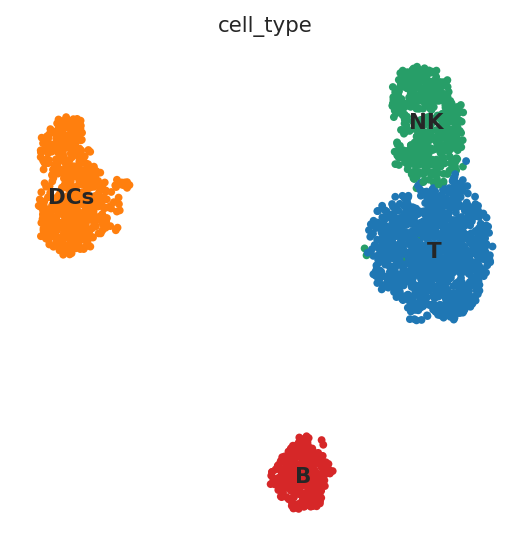

In [26]:
# Rename leiden clusters with corresponding cell types
cellTypes = {
    "0": "T",
    "1": "DCs",
    "2": "NK",
    "3": "B",
}
adata.obs["cell_type"] = adata.obs.leiden_scVI.replace(cellTypes)
sc.pl.umap(
    adata,
    color=["cell_type"],
    legend_loc="on data",
)

# Other ways to plot genes

## Heatmap

2023-08-17 19:57:05 - gene_heatmap - INFO: Saving figure to analysis/gene_heatmap.png


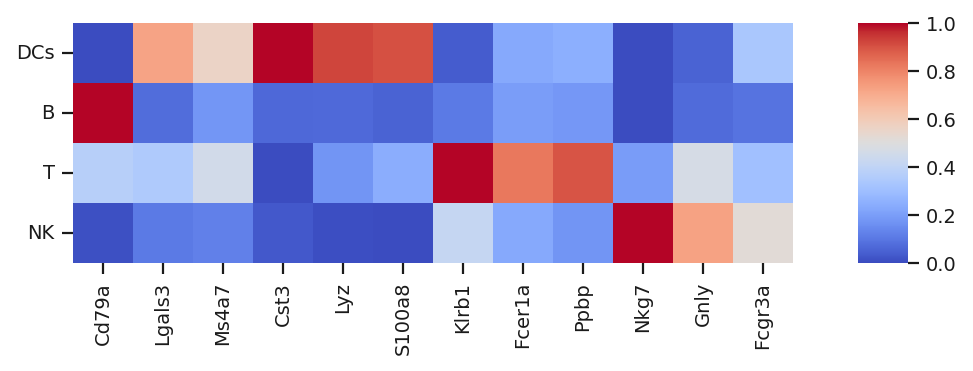

In [27]:
geneList = ["Cd79a", "Lyz", "Lgals3", "S100a8", "Gnly", "Nkg7", "Klrb1", "Fcgr3a", "Ms4a7", "Fcer1a", "Cst3", "Ppbp"]
rna.pl.gene_heatmap(
    adata,
    geneList,
    obs_key="cell_type", # categorical grouping to display
    obs_values=["DCs", "B", "NK", "T"], # values from obs key group to display
    layer="X", # can be a layer (i.e. 'raw_counts') or 'X'
    # cbar_args takes a list of integers to position color bar on heatmap. [x position, y position, width, height]. Default auto adjusts to right middle of heatmap.
    reverse_axis=False, # boolean to reverse x and y axes. Default False
    cell_size=30, # integer specifying the size of each cell in the heatmap
    dpi=80, # resolution of figure when saved
    save_path="analysis/gene_heatmap.png", # save_path specifies path to save figure
    # can also pass other arguments through to sns.clustermap() (see seaborn documentation for details):
    standard_scale=0,
    cmap="coolwarm"
)

## Violinplot

In [28]:
# Create fake condition/control groups
random.seed(0)
adata.obs["genotype"] = [bool(random.getrandbits(1)) for i in range(0,len(adata))]
adata.obs.genotype = adata.obs.genotype.replace({True: "KO", False: "WT"})

2023-08-17 19:57:06 - gene_violinplot - INFO: Saving figure to analysis/gene_single_violinplots.png


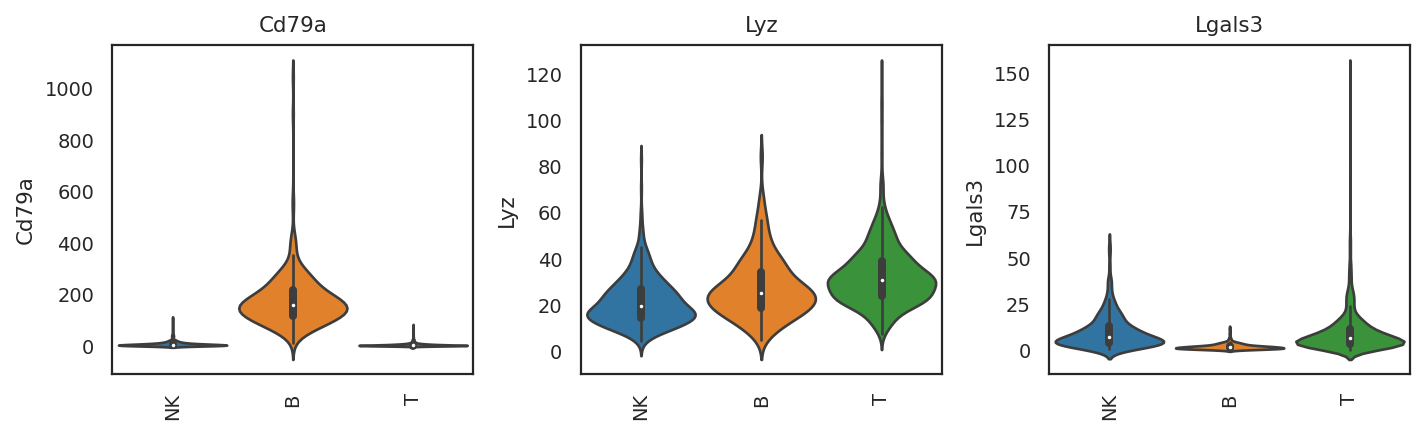

In [29]:
rna.pl.gene_violinplot(
    adata,
    geneList[0:3],
    x_key="cell_type", # categorical grouping to display on the x axis
    x_values=["NK", "B", "T"], # values from x key group to display. Defaults to ["All"] values
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    ncols=3, # number of columns for plots to display
    nrows=4, # number of rows for plots to display. ncols * nrows must be > or = total number of genes in geneList to display
    dpi=300, # resolution of figure when saved
    save_path="analysis/gene_single_violinplots.png", # save_path specifies path to save figure
    # can also pass other arguments through to sns.violinplot() (see seaborn documentation for details):
    palette="tab10"
)

### Gene violinplots can also be split across categorical cell labels such as genotype

2023-08-17 19:57:06 - gene_violinplot - INFO: Saving figure to analysis/gene_violinplots.png


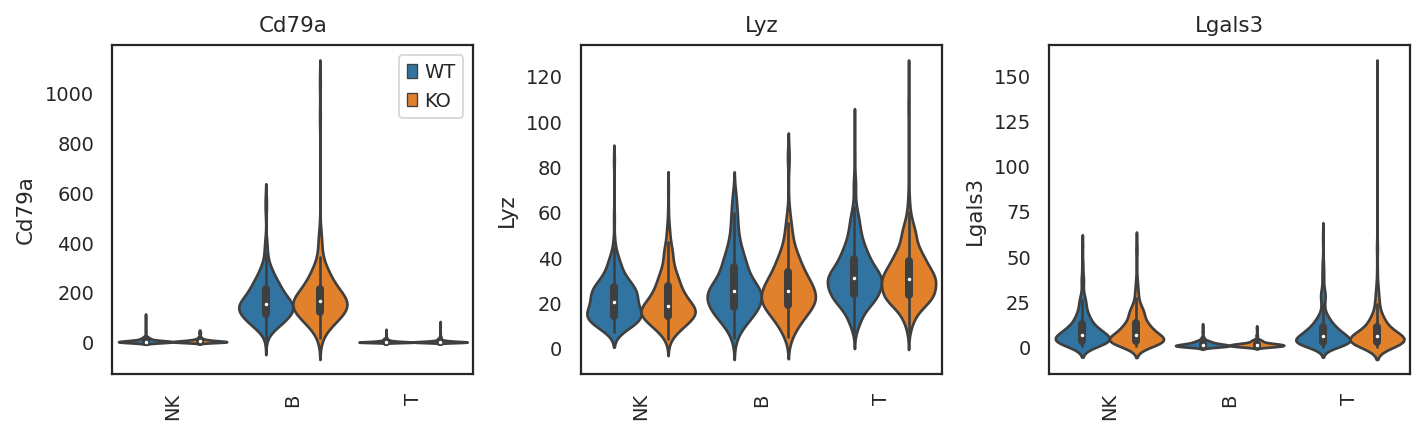

In [30]:
rna.pl.gene_violinplot(
    adata,
    geneList[0:3],
    x_key="cell_type", # categorical grouping to display on the x axis
    x_values=["NK", "B", "T"], # values from x key group to display. Defaults to ["All"] values
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    hue_key="genotype", # categorical grouping to color the grouped violin plots by
    hue_values=["WT", "KO"], # values from hue_key to display. Values will appear in legend. Defaults to ["All"] values
    ncols=3, # number of columns for plots to display
    nrows=4, # number of rows for plots to display. ncols * nrows must be > or = total number of genes in geneList to display
    dpi=300, # resolution of figure when saved
    save_path="analysis/gene_violinplots.png", # save_path specifies path to save figure
    # can also pass other arguments through to sns.violinplot() (see seaborn documentation for details):
    palette="tab10"
)

## Gene density plot

2023-08-17 19:57:10 - gene_density_plot - INFO: Saving figure to analysis/umap_marker_genes_density.png


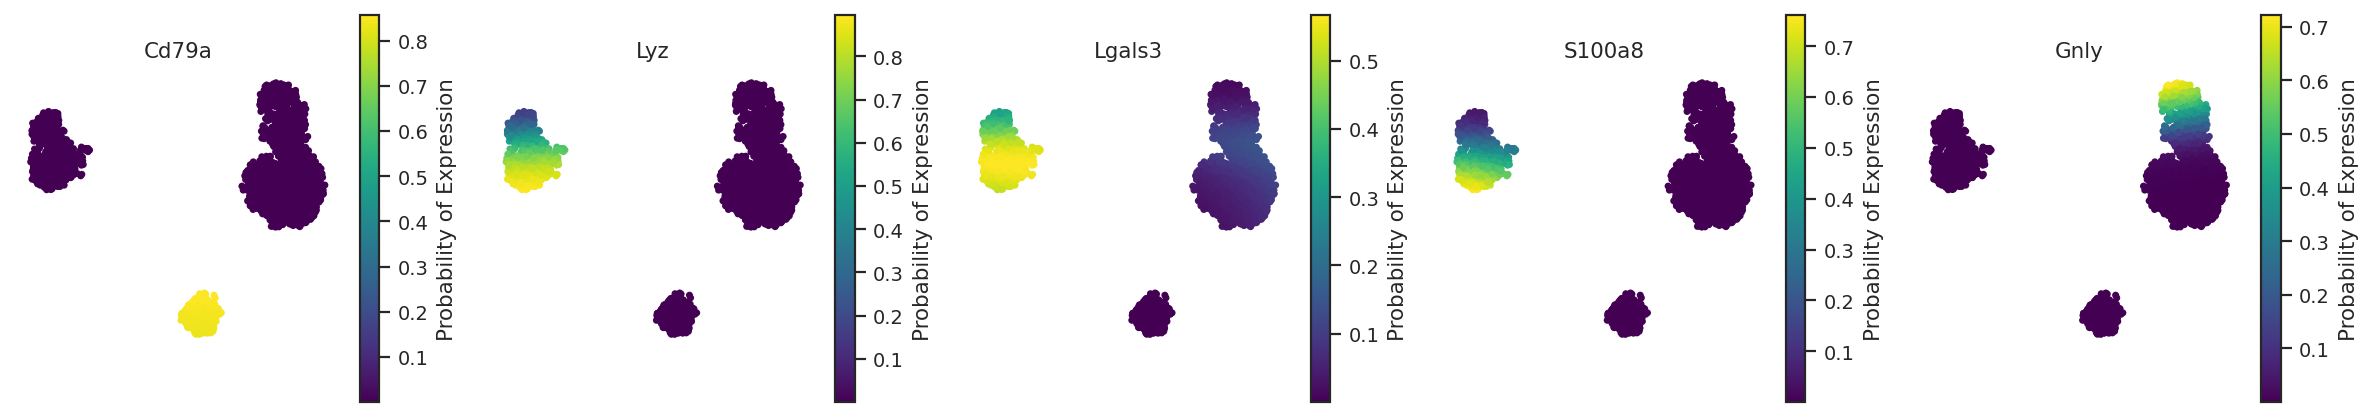

In [31]:
rna.pl.gene_density_plot(
    adata,
    geneList[0:5],
    data_loc="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    latent_rep="X_umap", # The latent rep to calculate density over
    cmap="viridis", # The colormap to use (see matplotlib.pyplot documentation for options)
    s=10, # Size of each data point
    ncols=5, # Number of columns in the figure
    figsize=(3, 3), # Size of each panel
    title=None,
    save_path="analysis/umap_marker_genes_density.png",
    dpi=300, # Resolution of saved figure
)

# Cluster DE marker genes

In [32]:
deGenes = rna.tl.cluster_de(
    adata,
    model, # Trained scVI model for the data
    cluster_key="cell_type", # cell type labels to calculate DE genes between
    lfc_mean_threshold=0, # Minimum LFC to consider a DE gene (default to only look at >0, i.e. genes with higher expression in a given cluster than everywhere else)
    bayes_factor_threshold=3, # Minimum bayes factor to consider a DE gene (see scVI documentation for explanation)
    non_zeroes_proportion_threshold=0.1, # Minimum proportion of cells with non-zero expression to consider a DE gene (removes stochastic noise/contamination)
    subset=True, # Whether to subset the DE gene list based on thresholds or return all genes in data
    save_path="analysis/DE", # Folder to save DE gene dataframes to
)

DE...: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


In [33]:
deGenes["B"].head(10)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Cd79b,0.9998,0.0002,8.516943,0.012276,0.000702,0.0,0.25,4.292124,4.342540,1.111537,...,3.530745,0.211539,0.935275,0.146811,137.786957,4.922921,True,B vs Rest,B,Rest
Cd79a,0.9996,0.0004,7.823621,0.017492,0.000470,0.0,0.25,5.763960,5.758623,1.605233,...,4.466022,0.051126,0.951456,0.042683,168.881973,1.511157,True,B vs Rest,B,Rest
Ms4a1,0.9992,0.0008,7.130086,0.007372,0.000210,0.0,0.25,5.509864,5.552023,1.479802,...,2.236248,0.058161,0.867314,0.055816,83.727707,1.763732,True,B vs Rest,B,Rest
Tcl1a,0.9986,0.0014,6.569875,0.010517,0.000287,0.0,0.25,5.931237,5.824034,2.094283,...,2.181231,0.026735,0.624595,0.021576,90.794327,0.796050,True,B vs Rest,B,Rest
Cd74,0.9976,0.0024,6.029880,0.084589,0.009636,0.0,0.25,3.318548,3.428888,0.886318,...,28.466021,5.780974,1.000000,0.836304,1098.128052,99.544075,True,B vs Rest,B,Rest
Hla-dqb1,0.9966,0.0034,5.680571,0.009696,0.000645,0.0,0.25,4.536808,4.524456,1.657590,...,2.857607,0.316135,0.873786,0.155722,111.458817,4.681306,True,B vs Rest,B,Rest
Hla-dra,0.9958,0.0042,5.468460,0.063653,0.005747,0.0,0.25,4.339561,4.645060,1.672395,...,18.692566,4.359753,1.000000,0.501407,720.412476,56.159050,True,B vs Rest,B,Rest
Hla-dqa1,0.9950,0.0050,5.293303,0.011420,0.000744,0.0,0.25,5.156289,5.110248,2.124175,...,3.022655,0.369605,0.912621,0.123358,118.121819,4.685003,True,B vs Rest,B,Rest
Igll5,0.9948,0.0052,5.253881,0.005375,0.000109,0.0,0.25,6.710568,6.664472,3.062139,...,1.598706,0.021107,0.229773,0.011726,58.142479,0.394110,True,B vs Rest,B,Rest
Fcrla,0.9890,0.0110,4.498798,0.001645,0.000097,0.0,0.25,4.557243,4.517633,2.325383,...,0.456311,0.006567,0.304207,0.006098,17.681627,0.191726,True,B vs Rest,B,Rest


# Cell type similarity

## Get immgen cell type signatures

In [34]:
# Download and load the immgen cell type signature data to a folder at save_path
immgen = rna.tl.get_immgen_similarity_signatures(save_path="data") 
immgen

,SC_LT34F_BM,SC_LTSL_BM,SC_STSL_BM,SC_LTSL_FL,SC_STSL_FL,SC_MPP34F_BM,SC_ST34F_BM,SC_CMP_BM,SC_MEP_BM,SC_GMP_BM,...,Ep_MEChi_Th,Fi_MTS15+_Th,Fi_Sk,FRC_MLN,FRC_SLN,LEC_MLN,LEC_SLN,BEC_MLN,BEC_SLN,St_31-38-44-_SLN
gene_name,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,6.797117,6.360333,6.662006,6.427335,6.437454,6.679156,6.790981,6.943933,7.635508,7.117373,...,6.476976,6.609829,6.502716,6.731251,6.780717,6.816932,7.149442,6.942866,6.996807,6.529115
0610009L18Rik,7.316544,8.168883,7.861428,7.800822,7.507517,7.541081,7.455853,7.620293,7.114336,7.677924,...,7.996490,7.452834,7.537444,7.763949,7.545011,7.574276,7.177180,7.643272,7.463900,7.600032
0610010F05Rik,7.400632,7.056768,7.160870,7.381136,7.572367,7.270314,7.473560,7.626782,7.475628,6.164643,...,7.275631,6.908525,6.612712,5.439932,6.098217,6.716511,7.119968,6.492121,6.728206,6.356234
0610010K14Rik,9.246308,9.295594,8.917933,9.367240,9.247446,9.598990,9.599037,9.286498,9.292842,10.031798,...,8.417190,8.377814,9.693119,8.777117,8.631075,9.212467,9.399297,9.395945,9.408379,8.609123
0610038B21Rik,5.861660,6.171731,5.818086,6.296947,6.031117,6.096877,5.932255,6.636587,6.368213,6.342167,...,6.041710,5.763672,6.043463,6.192078,5.952597,5.838795,5.687346,6.040654,5.863289,6.197374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyx,9.272275,10.091382,10.290411,9.686166,9.693199,9.263065,9.275447,9.290837,7.203798,9.167604,...,7.627300,8.744558,9.711825,9.024311,8.776755,9.386212,9.366995,9.160313,9.040734,9.292802
Zzef1,8.120165,8.430231,8.487346,8.168742,8.455237,7.849267,8.083128,8.474797,8.285157,7.571358,...,7.780487,8.307825,7.919775,7.882258,8.075704,8.389248,8.321919,8.261564,8.307784,7.852217
Zzz3,9.536164,9.641560,9.469255,9.798141,9.703494,9.309358,9.564820,9.540835,9.438682,7.894254,...,8.883996,9.326355,8.868233,8.466615,8.921892,8.794250,9.027696,8.824545,8.883593,8.514935


## Cosine similarity to immgen cell types

In [35]:
# Cell type similarity scores for each cell are added as columns to adata.obs
adata=rna.tl.cell_type_similarity(
    adata,
    signatures=immgen, # The gene x cell type DataFrame containing cell type signatures for scoring
)
# Each column is named (cell_type)_cosine_similarity_cell_z_score

2023-08-17 19:57:19 - cell_type_similarity - INFO: Scaling cosine similarity scores to z-scores by cell


In [36]:
# List all similarity scores
[i for i in adata.obs.columns if "cosine_similarity" in i]

['SC_LT34F_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_BM_cosine_similarity_cell_z_score',
 'SC_STSL_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_FL_cosine_similarity_cell_z_score',
 'SC_STSL_FL_cosine_similarity_cell_z_score',
 'SC_MPP34F_BM_cosine_similarity_cell_z_score',
 'SC_ST34F_BM_cosine_similarity_cell_z_score',
 'SC_CMP_BM_cosine_similarity_cell_z_score',
 'SC_MEP_BM_cosine_similarity_cell_z_score',
 'SC_GMP_BM_cosine_similarity_cell_z_score',
 'SC_CDP_BM_cosine_similarity_cell_z_score',
 'SC_MDP_BM_cosine_similarity_cell_z_score',
 'MLP_BM_cosine_similarity_cell_z_score',
 'MLP_FL_cosine_similarity_cell_z_score',
 'proB_CLP_BM_cosine_similarity_cell_z_score',
 'proB_FrA_BM_cosine_similarity_cell_z_score',
 'proB_FrBC_BM_cosine_similarity_cell_z_score',
 'preB_FrC_BM_cosine_similarity_cell_z_score',
 'preB_FrD_BM_cosine_similarity_cell_z_score',
 'B_FrE_BM_cosine_similarity_cell_z_score',
 'proB_CLP_FL_cosine_similarity_cell_z_score',
 'proB_FrA_FL_cosine_similarity_cell_z

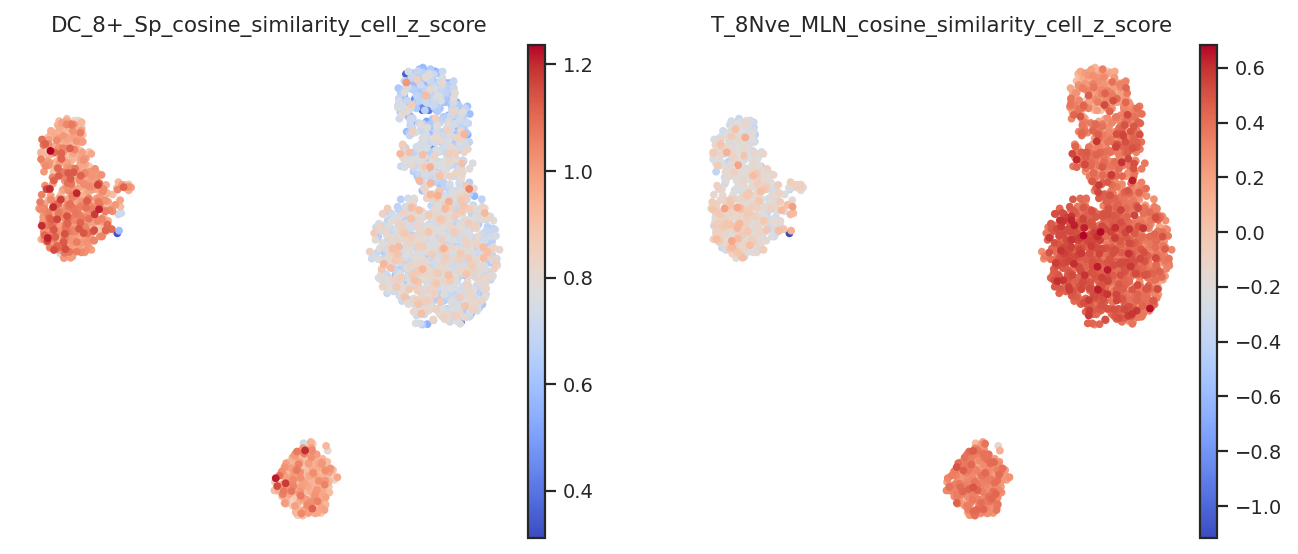

In [37]:
# Plot selected similarity scores
sc.pl.umap(
    adata,
    color=["DC_8+_Sp_cosine_similarity_cell_z_score", "T_8Nve_MLN_cosine_similarity_cell_z_score"],
    cmap="coolwarm",
)

## Create a new signature file for similarity scoring using this data

In [38]:
# Pseudobulk a single cell datset by cell type to create new cell type signatures for scoring
rna.tl.create_cell_type_signature(
    adata,
    save_path="analysis/pbmc3k_cell_type_signature.csv", # The path to save the signature to
    cell_type_labels="cell_type", # The column in adata.obs that contains cell type annotations
    data_loc="raw", # The location of expression data to use (must be cell size normalized and log-transformed counts).
                    # By default this uses the raw attribute, which in this pipeline contains ALL genes in the dataset,
                    # But the subset of genes within adata.X or a layer could be used as long as the expression data is 
                    # log-transformed counts.
)

2023-08-17 19:57:19 - create_cell_type_signature - INFO: Saving signature DataFrame to analysis/pbmc3k_cell_type_signature.csv


,T,B,DCs,NK
Al627309.1,0.002842,0.000000,0.015375,0.004107
Ap006222.2,0.001511,0.000000,0.002977,0.003148
Rp11-206l10.2,0.001720,0.009756,0.001505,0.000000
Rp11-206l10.9,0.000000,0.000000,0.005855,0.000000
Fam87b,0.000000,0.000000,0.004120,0.000000
...,...,...,...,...
Ac011841.1,0.000000,0.006408,0.000000,0.003986
Al354822.1,0.002887,0.006834,0.007071,0.000000
Kir2dl2,0.000000,0.000000,0.000000,0.003952
Pnrc2-1,0.084884,0.056002,0.050851,0.076046


# Differential density

In [39]:
# Create fake condition/control groups
random.seed(0)
adata.obs["genotype"] = [bool(random.getrandbits(1)) for i in range(0,len(adata))]
adata.obs.genotype = adata.obs.genotype.replace({True: "KO", False: "WT"})

In [40]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="genotype", # The column in adata.obs containing condition/control labels
    groups=["KO", "WT"], # The condition/control labels in adata.obs[group_by] to use
    latent_rep="X_umap", # The latent representation to calculate density over
    key_added="KO/WT_log_density_ratio", # The column to add to adta.obs with the differential density ratio
)

2023-08-17 19:57:19 - log_density_ratio - INFO: Calculating log density ratio of WT/KO


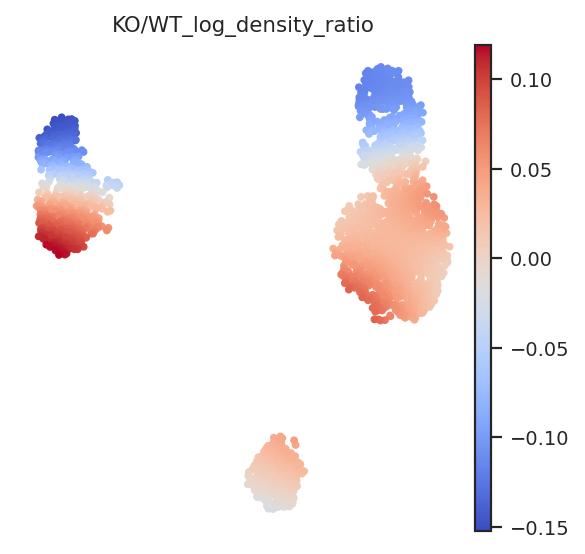

In [41]:
sc.pl.umap(
    adata,
    color="KO/WT_log_density_ratio",
    cmap="coolwarm"
)
# As expected there is not significant enrichment of either randomly assigned genotype in a particular region on the UMAP (note the colorbar scale)

# Save anndata

In [42]:
adata.write("data/pbmc_3k_1200_hvgs.h5ad")

# Other tools

## Get expression matrix

In [43]:
# Returns a cell x gene DataFrame with expression data from 'adata.X' 'adata.raw' or a layer in 'adata.layers'
data = rna.tl.get_expression_matrix(
    adata,
    "scVI_normalized", # Can be 'X', 'raw', or a layer in 'adata.layers'
)
data.index=adata.obs.index
data.columns=adata.var_names
data

,Isg15,Cpsf3l,Mrpl20,Rer1,Lrrc47,Tnfrsf25,Tnfrsf9,Rbp7,Srm,Ubiad1,...,Map3k7cl,Ifngr2,Ttc3,Dscr3,C21orf33,Icoslg,Sumo3,S100b,Mt-co2,Mt-nd6
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,7.102357,1.597872,14.832851,10.040731,2.365237,11.680295,0.737732,0.024810,5.522147,2.642613,...,0.112329,0.201723,15.286035,0.390382,2.205375,0.016554,4.800915,5.239383,315.012024,4.441800
AAACATTGAGCTAC-1,15.229803,1.803777,10.035845,11.664472,0.539089,0.262639,0.274768,0.035629,2.804478,14.859688,...,0.130174,3.466640,6.261030,28.821985,4.118064,0.883157,3.869360,0.270017,169.416306,3.266064
AAACATTGATCAGC-1,42.400314,4.668079,16.249533,5.577284,5.984211,12.300083,0.015359,0.052773,21.317230,0.504810,...,0.264854,3.352660,17.212067,1.112477,1.897363,0.080783,7.566671,1.483495,257.675079,0.886601
AAACCGTGCTTCCG-1,67.552727,1.548532,3.514173,8.979177,0.700928,0.045759,0.065644,1.251981,8.659072,0.183811,...,0.117014,6.982827,4.539423,0.496838,1.145072,1.286381,4.489483,0.249150,109.934135,0.960886
AAACGCACTGGTAC-1,42.057594,38.265743,20.203388,9.243329,0.901978,11.345248,0.114633,0.676163,13.430662,5.347405,...,0.827812,2.540133,3.595500,2.214534,3.155924,1.497083,9.305819,1.266322,213.552765,7.214509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACACCTGA-1,38.282749,3.478415,9.755084,15.134913,1.414182,0.170034,0.905523,0.004518,10.566669,0.690247,...,0.050228,4.032824,3.787982,3.649578,1.162892,2.331045,8.999220,1.013430,110.837685,12.100290
TTTCGAACTCTCAT-1,72.954330,0.550716,3.930763,7.445375,0.543568,0.022789,0.795740,1.671264,7.565594,0.322782,...,0.223574,5.762744,5.761859,0.820248,2.431378,0.354163,3.960954,0.150294,84.741859,1.515885
TTTCTACTGAGGCA-1,31.935694,7.983189,8.696520,4.599047,1.052005,0.983002,0.027355,0.033734,20.783264,0.360217,...,0.140537,4.197083,5.428267,14.703284,2.332753,1.472735,2.935915,0.827657,172.233307,3.114795
